正在執行傳統 FCM...
正在執行 RFCM (Size-insensitive)...


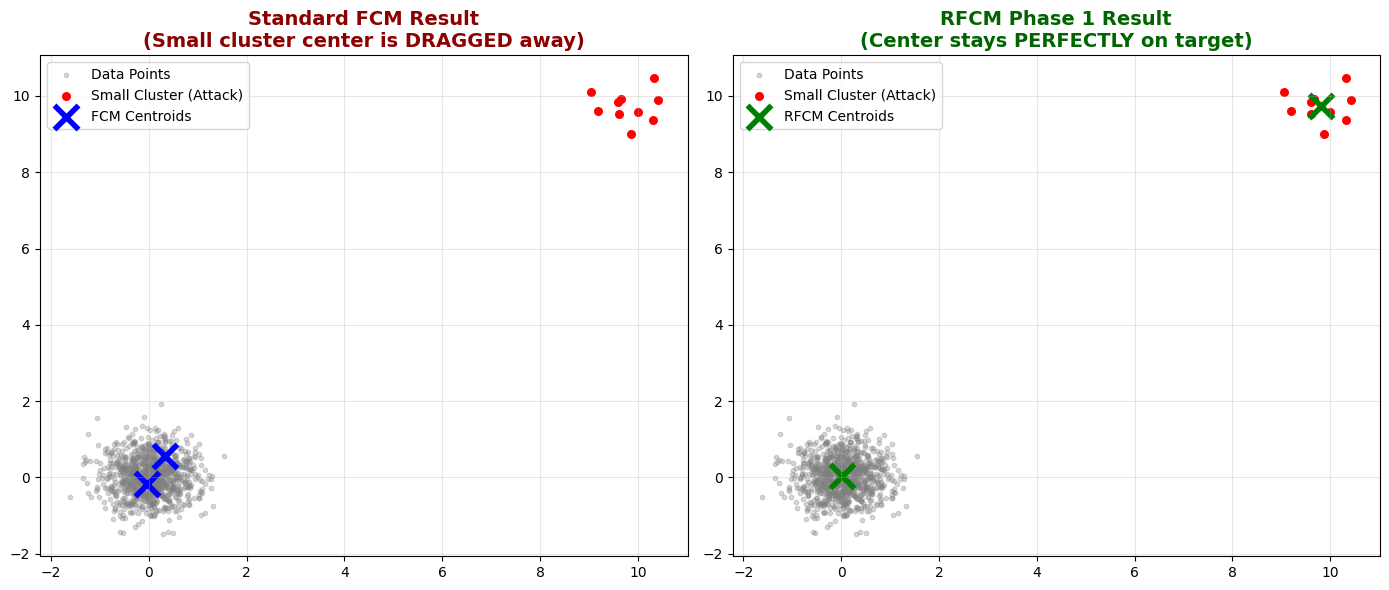

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_imbalanced_data():
    """
    生成極端不平衡的測試數據
    - 左邊 (Cluster A): 1000 個點，代表龐大的正常流量
    - 右邊 (Cluster B): 10 個點，代表稀少的攻擊流量
    """
    np.random.seed(42) # 固定隨機種子以確保結果可重現
    
    # 正常流量：1000 點聚集在 (0, 0)
    X_large = np.random.normal(loc=0, scale=0.5, size=(1000, 2))
    
    # 攻擊流量：10 點聚集在 (10, 0)
    # 我們刻意讓它離很遠，測試演算法會不會被數量差距拉走
    X_small = np.random.normal(loc=10, scale=0.5, size=(10, 2))
    
    X = np.vstack([X_large, X_small])
    return X

def standard_fcm(X, c=2, m=2, max_iter=100, error=1e-5):
    """
    傳統 Fuzzy C-Means 演算法
    """
    n_samples = X.shape[0]
    # 隨機初始化隸屬度矩陣 U
    U = np.random.rand(c, n_samples)
    U = U / np.sum(U, axis=0) # 歸一化，確保總和為 1 (這是問題所在!)
    
    centers = np.zeros((c, X.shape[1]))
    
    for iteration in range(max_iter):
        U_prev = U.copy()
        
        # 1. 更新中心點 (Update Centers)
        um = U ** m
        centers = um.dot(X) / um.sum(axis=1)[:, None]
        
        # 2. 更新隸屬度 (Update Membership)
        dist = np.linalg.norm(X - centers[:, None, :], axis=2)
        dist = np.fmax(dist, 1e-10) # 避免除以零
        
        inv_dist_pow = dist ** (-2 / (m - 1))
        U = inv_dist_pow / inv_dist_pow.sum(axis=0) # 強制歸一化
        
        if np.linalg.norm(U - U_prev) < error:
            break
            
    return centers

def size_insensitive_rfcm(X, c=2, m=2, p=2, max_iter=100, error=1e-5):
    """
    RFCM 第一階段 (Size-insensitive) 演算法
    關鍵差異：移除了「隸屬度總和為 1」的限制，引入 rho 參數
    """
    n_samples = X.shape[0]
    U = np.random.rand(c, n_samples)
    U = U / np.sum(U, axis=0)
    
    centers = np.zeros((c, X.shape[1]))
    
    for iteration in range(max_iter):
        U_prev = U.copy()
        
        # 1. 更新中心點 (與 FCM 相同)
        um = U ** m
        centers = um.dot(X) / um.sum(axis=1)[:, None]
        
        # --- RFCM 獨有的神奇修正步驟 ---
        
        # 2. 確定每個點目前的「贏家」群聚 (Hard Partition)
        labels = np.argmax(U, axis=0)
        
        # 3. 計算調節因子 S_i (反映群聚的大小與密度)
        S = np.zeros(c)
        for i in range(c):
            indices = np.where(labels == i)[0]
            if len(indices) > 0:
                # 這裡的公式會懲罰過大的群聚
                sum_val = np.sum(1 + U[i, indices] / (n_samples ** p))
                S[i] = sum_val / n_samples
        
        # 4. 計算 rho (鬆綁約束條件)
        # 每個點都有自己的 rho，不再強制總和為 1
        winner_indices = labels
        rho = 1 - S[winner_indices]
        
        # 偏微分項 (用於更新公式)
        d_rho_du = np.zeros((c, n_samples))
        val = -1.0 / (n_samples ** (p + 1))
        for j in range(n_samples):
            d_rho_du[winner_indices[j], j] = val
            
        # 5. 更新隸屬度 (使用修正後的複雜公式)
        dist_sq = np.linalg.norm(X - centers[:, None, :], axis=2) ** 2
        dist_sq = np.fmax(dist_sq, 1e-10)
        
        # 修正後的距離項，包含了 rho 的影響
        term = (1 - d_rho_du) * dist_sq
        
        exponent = 1.0 / (m - 1)
        term_pow = term ** exponent
        inv_term_pow = 1.0 / term_pow
        sum_inv_term_pow = np.sum(inv_term_pow, axis=0)
        
        U_new = np.zeros_like(U)
        for i in range(c):
            U_new[i, :] = rho * inv_term_pow[i, :] / sum_inv_term_pow
        
        U = np.fmax(U_new, 0) # 確保非負
        
        if np.linalg.norm(U - U_prev) < error:
            break
            
    return centers

# --- 執行實驗 ---
X = generate_imbalanced_data()

# 跑兩種演算法
print("正在執行傳統 FCM...")
centers_fcm = standard_fcm(X, c=2)
print("正在執行 RFCM (Size-insensitive)...")
centers_rfcm = size_insensitive_rfcm(X, c=2, p=2)

# --- 繪圖呈現結果 ---
plt.figure(figsize=(14, 6))

# 左圖：傳統 FCM
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c='gray', alpha=0.3, s=10, label='Data Points')
plt.scatter(X[1000:, 0], X[1000:, 1], c='red', s=30, label='Small Cluster (Attack)')
# 畫出中心點
plt.scatter(centers_fcm[:, 0], centers_fcm[:, 1], c='blue', s=300, marker='x', linewidths=4, label='FCM Centroids')
plt.title('Standard FCM Result\n(Small cluster center is DRAGGED away)', fontsize=14, fontweight='bold', color='darkred')
plt.grid(True, alpha=0.3)
plt.legend()

# 右圖：RFCM
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c='gray', alpha=0.3, s=10, label='Data Points')
plt.scatter(X[1000:, 0], X[1000:, 1], c='red', s=30, label='Small Cluster (Attack)')
# 畫出中心點
plt.scatter(centers_rfcm[:, 0], centers_rfcm[:, 1], c='green', s=300, marker='x', linewidths=4, label='RFCM Centroids')
plt.title('RFCM Phase 1 Result\n(Center stays PERFECTLY on target)', fontsize=14, fontweight='bold', color='darkgreen')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()